In [114]:
import os

import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [3]:
DATA_DIR = "D:\\works\\store sales data\\sales_data_v2"

In [4]:
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(DATA_DIR):
    for file in f:
        files.append(os.path.join(r, file))

In [5]:
dfs = [pd.read_csv(file) for file in files]

In [6]:
print([df.shape for df in dfs])

[(11584, 10), (2327, 10), (7921, 10), (9526, 10), (10049, 10), (16238, 10), (462, 10), (2503, 10), (2503, 10)]


In [7]:
[df["Store Code"].unique() for df in dfs]

[array(['Store 1'], dtype=object),
 array(['Store 2'], dtype=object),
 array(['Store 2'], dtype=object),
 array(['Store 3'], dtype=object),
 array(['Store 4'], dtype=object),
 array(['Store 5'], dtype=object),
 array(['Store 5'], dtype=object),
 array(['Store 6'], dtype=object),
 array(['Store 6'], dtype=object)]

In [8]:
# Concatenating data of same store
df_store_1 = dfs[0].drop_duplicates()
df_store_2 = dfs[1].append(dfs[2]).drop_duplicates()
df_store_3 = dfs[3].drop_duplicates()
df_store_4 = dfs[4].drop_duplicates()
df_store_5 = dfs[5].append(dfs[6]).drop_duplicates()
df_store_6 = dfs[7].append(dfs[8]).drop_duplicates()

In [9]:
dfs = [df_store_1, df_store_2, df_store_3, df_store_4, df_store_5, df_store_6]

In [10]:
[df["Store Code"].unique() for df in dfs]

[array(['Store 1'], dtype=object),
 array(['Store 2'], dtype=object),
 array(['Store 3'], dtype=object),
 array(['Store 4'], dtype=object),
 array(['Store 5'], dtype=object),
 array(['Store 6'], dtype=object)]

In [11]:
print([df.shape for df in dfs])

[(11163, 10), (9001, 10), (8790, 10), (9311, 10), (15247, 10), (2445, 10)]


In [12]:
def preprocess_data(df):
    # Keep rows where price > 0 
    df = df[df["Sales Price"] > 0]

    # Keep rows where MRP >= sell price
    df = df[df["MRP"] >= df["Sales Price"]]
    
    print('Number of missing values:\n',df.isnull().sum())
    df = df[~df["Category"].isnull()]
    
    # Remove returned items
    df = df[df["Sales Qty"]>0]

    df["Sale Date"] = pd.to_datetime(df["Sale Date"])
    return df

preprocessed_dfs = [preprocess_data(df) for df in dfs]

Number of missing values:
 SKU Code       0
Brand Code     0
Category       0
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP            0
Sales Price    0
Sales Qty      0
dtype: int64
Number of missing values:
 SKU Code       0
Brand Code     0
Category       0
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP            0
Sales Price    0
Sales Qty      0
dtype: int64
Number of missing values:
 SKU Code       0
Brand Code     8
Category       8
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP            0
Sales Price    0
Sales Qty      0
dtype: int64
Number of missing values:
 SKU Code       0
Brand Code     0
Category       0
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP            0
Sales Price    0
Sales Qty      0
dtype: int64
Number of missing values:
 SKU Code       0
Brand Code     0
Category       0
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP           

In [13]:
print([df.shape for df in preprocessed_dfs])

[(9610, 10), (7939, 10), (7895, 10), (8447, 10), (13359, 10), (2337, 10)]


In [14]:
#Sale Dates 
[df["Sale Date"].describe() for df in preprocessed_dfs]

[count                    9610
 unique                    278
 top       2017-07-29 00:00:00
 freq                      109
 first     2017-05-24 00:00:00
 last      2018-02-28 00:00:00
 Name: Sale Date, dtype: object, count                    7939
 unique                    365
 top       2017-12-30 00:00:00
 freq                       62
 first     2017-03-01 00:00:00
 last      2018-02-28 00:00:00
 Name: Sale Date, dtype: object, count                    7895
 unique                    176
 top       2017-09-30 00:00:00
 freq                      134
 first     2017-09-06 00:00:00
 last      2018-02-28 00:00:00
 Name: Sale Date, dtype: object, count                    8447
 unique                    188
 top       2017-09-09 00:00:00
 freq                      125
 first     2017-08-23 00:00:00
 last      2018-02-28 00:00:00
 Name: Sale Date, dtype: object, count                   13359
 unique                    422
 top       2017-11-04 00:00:00
 freq                      113
 fir

In [15]:
def get_features(df):
    df["year"] = df["Sale Date"].dt.year
    df["week"] = df["Sale Date"].dt.week
    df["month"] = df["Sale Date"].dt.month
    df["Amount"] = df["Sales Price"] * df["Sales Qty"]
    df["discount"] = df.apply(lambda x: 100*(1 - (x["Sales Price"]/x["MRP"])),  axis=1)
    return df


In [16]:
features_dfs = [get_features(df) for df in preprocessed_dfs]

In [64]:
def create_plot(df, by):
    groupdf = df.groupby(by)["Sales Qty"].sum()
    groupdf = groupdf.reset_index()
  
    values = list(groupdf.loc[:, 'Sales Qty'])
        
    g = sns.FacetGrid(groupdf, col="year")
    g.map(plt.bar, "month", "Sales Qty")
    g.fig.suptitle(groupdf["Store Code"].unique()[0])

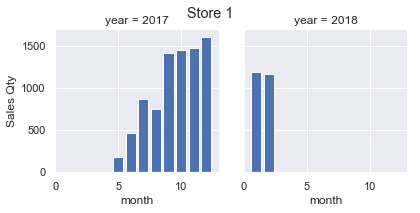

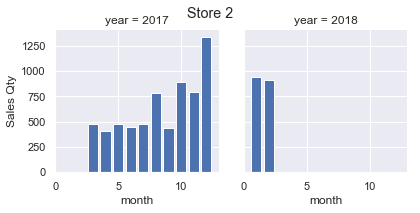

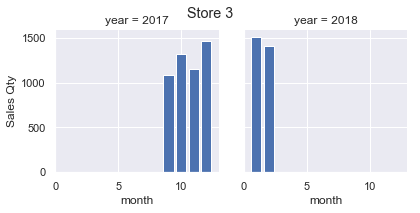

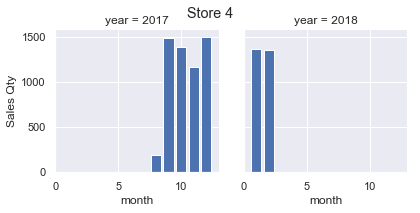

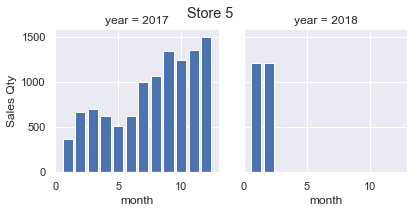

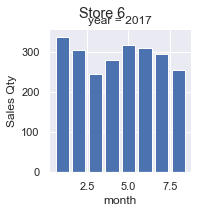

In [65]:
for df in features_dfs:
    create_plot(df, by=["year", "month", "Store Code"])

In [19]:
def category_monthly_stats(df):
    df["average_selling_price"] = np.sum(df["Amount"]) / np.sum(df["Sales Qty"])
    df["max_discount"] = df["discount"].max()
    return df

In [115]:
def nonzero_mode(arr):
    return stats.mode(arr[np.nonzero(arr)]).mode

In [116]:
master_df = pd.concat(features_dfs)

In [117]:
nonzero_mode(np.array(master_df[master_df["month"]==12].head(100)["discount"]))

array([9.53571429])

In [128]:
def get_discount(df):
    arr = nonzero_mode(np.array(df["discount"]))
    if len(arr) > 0:
        return arr[0]
    return 0
#     return np.sum((df["discount"] * df["Sales Qty"]))/np.sum(df["Sales Qty"])

In [141]:
stores = master_df["Store Code"].unique().tolist()
stores.sort()

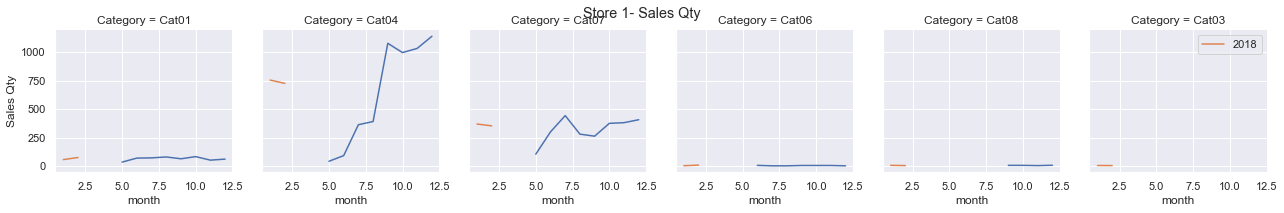

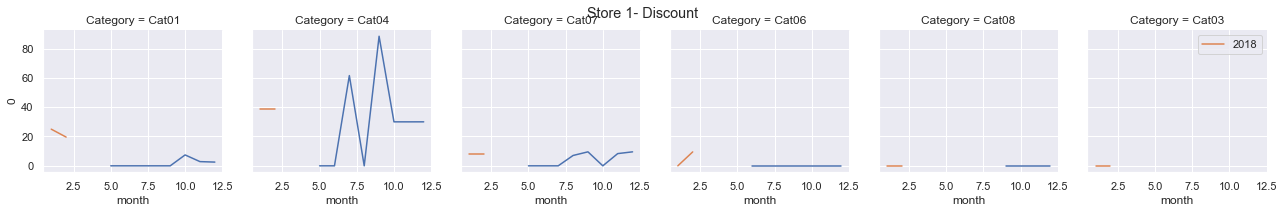

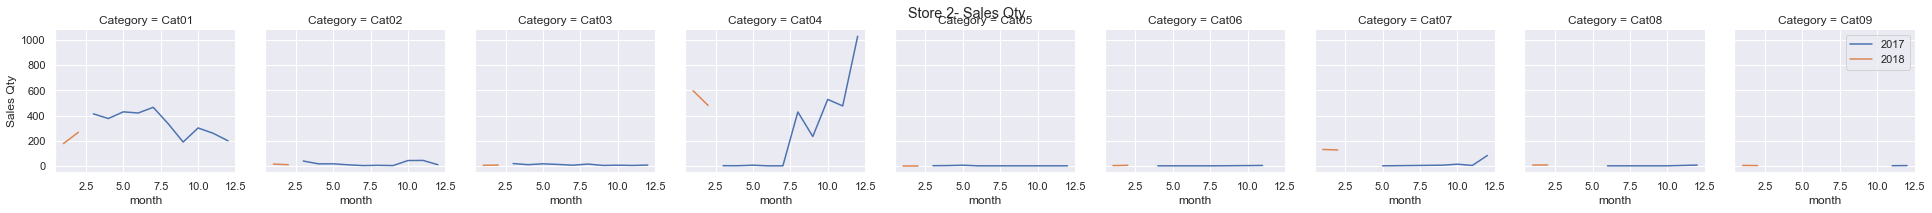

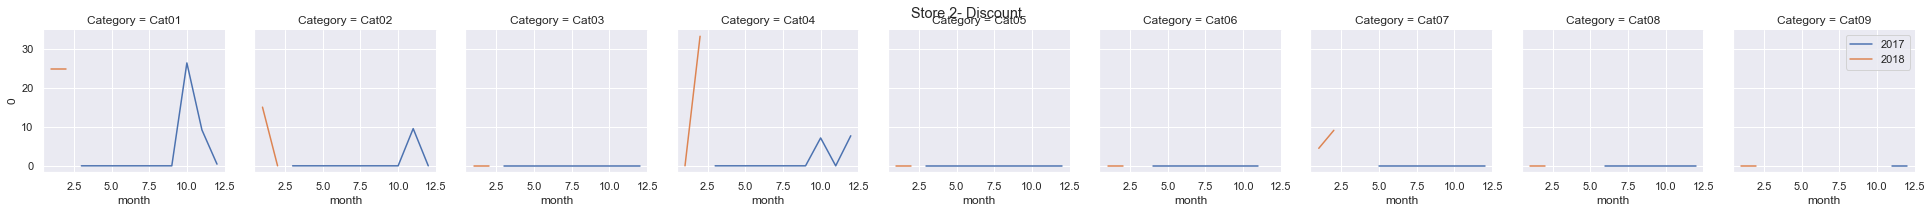

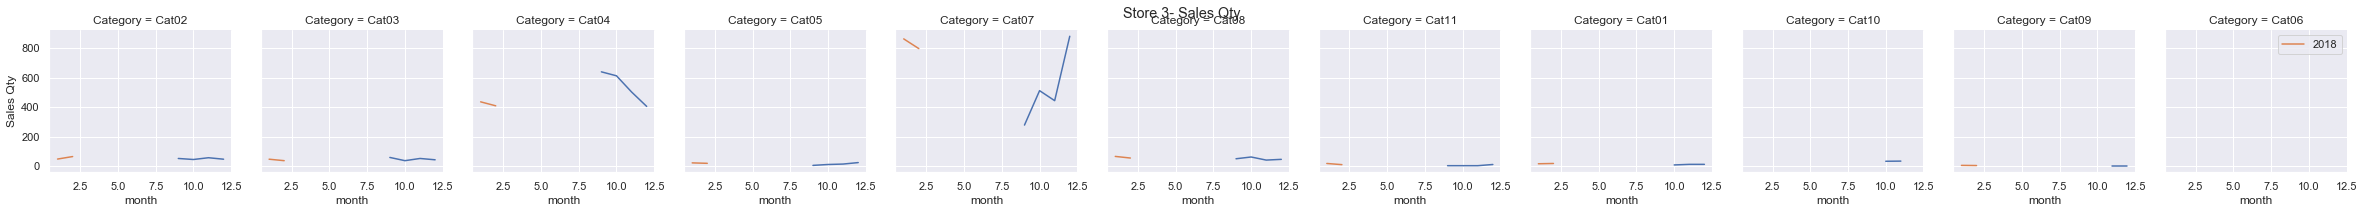

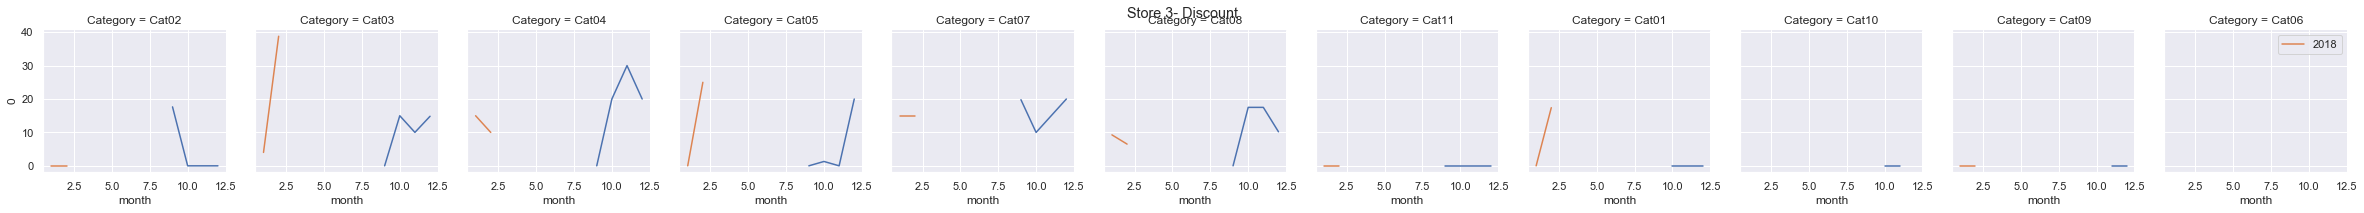

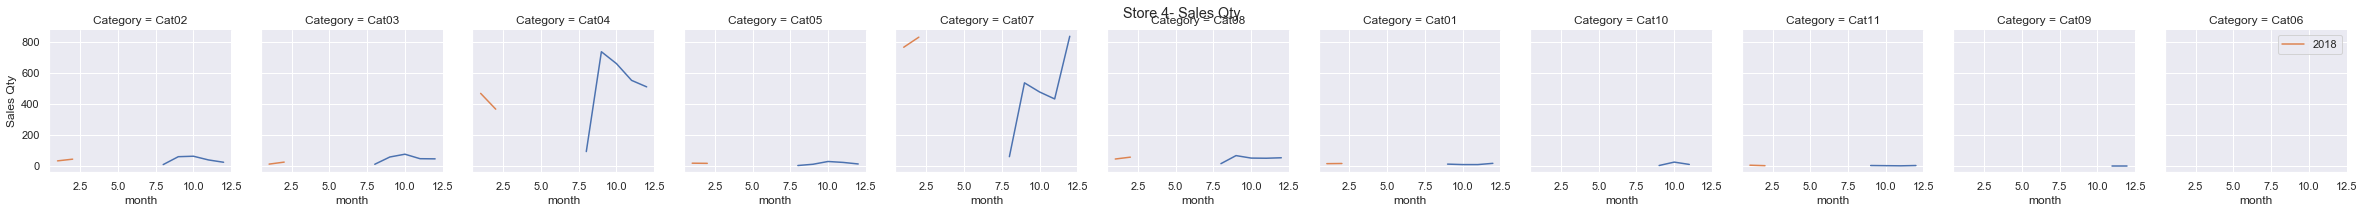

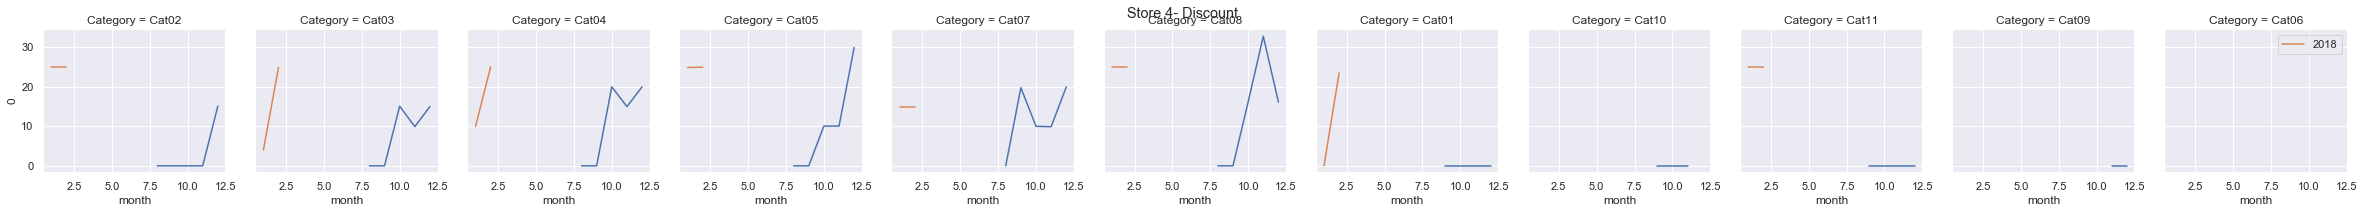

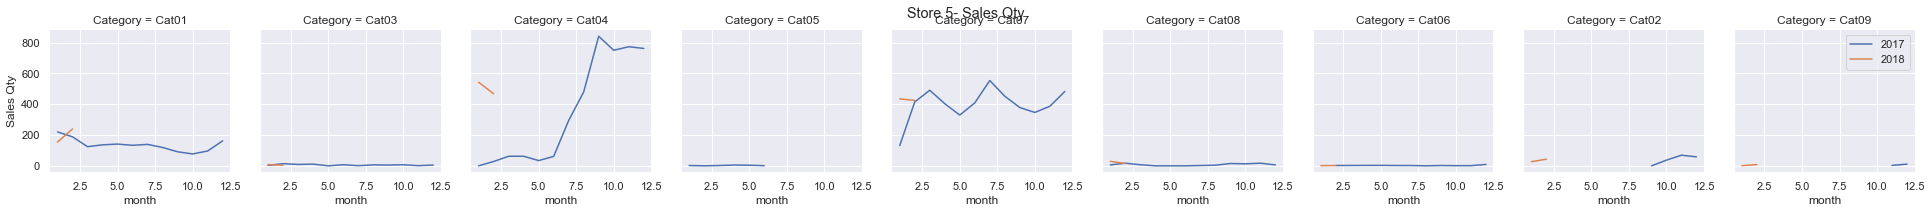

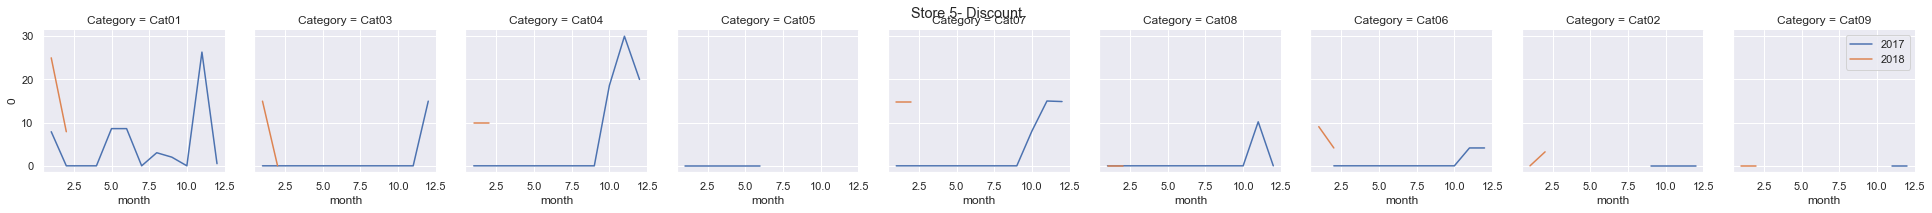

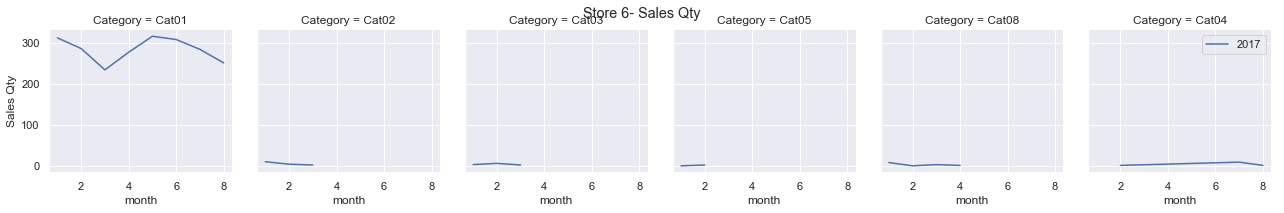

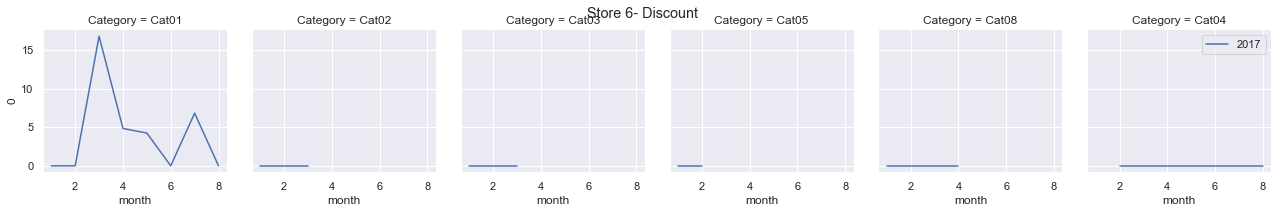

In [142]:
grouped = master_df.groupby(["Store Code"])

for store_code in stores:
    temp = grouped.get_group(store_code)
    frame = temp.groupby(["year", "month", "Category"])["Sales Qty"].sum().reset_index()

    if frame.shape[0] > 0:
        g = sns.FacetGrid(frame, col="Category", hue="year", margin_titles=True)
        g.map(plt.plot, "month", "Sales Qty")
        g.fig.suptitle(store_code + "- Sales Qty")
        
    plt.legend()
        
    frame = temp.groupby(["year", "month", "Category"]).apply(get_discount).reset_index()
 
    if frame.shape[0] > 0:
        g = sns.FacetGrid(frame, col="Category", hue="year", margin_titles=True)
        g.map(plt.plot, "month", 0)
        g.fig.suptitle(store_code + "- Discount")
    plt.legend()
        
    

In [132]:
categories = master_df["Category"].unique().tolist()
categories.sort()

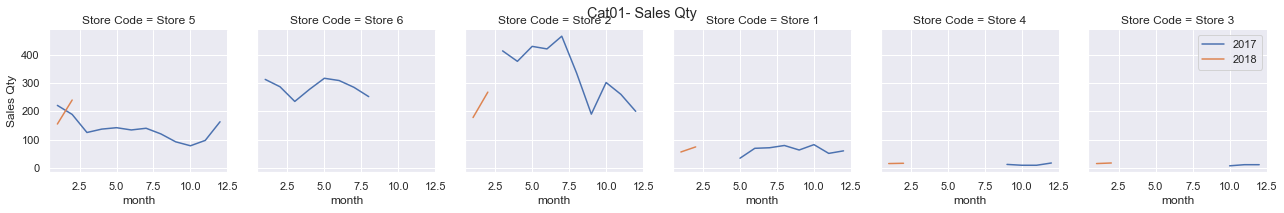

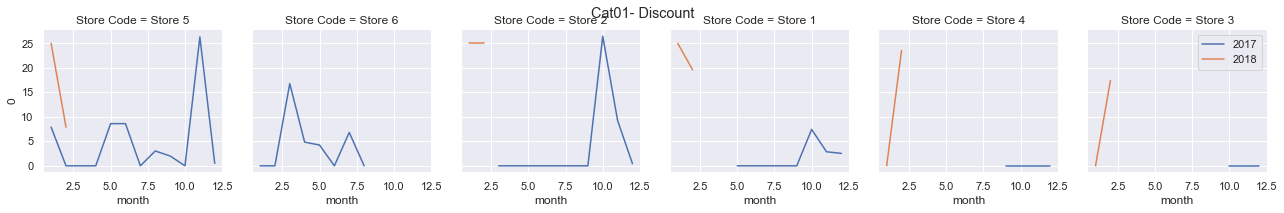

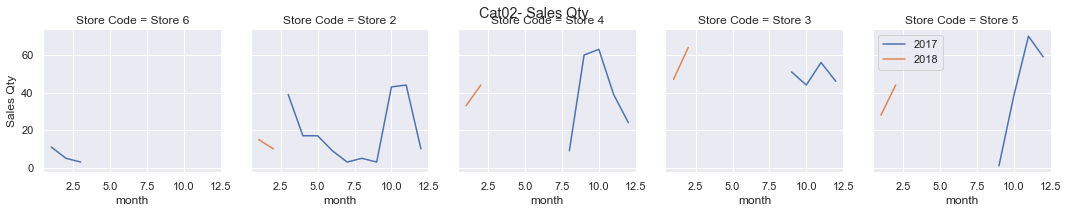

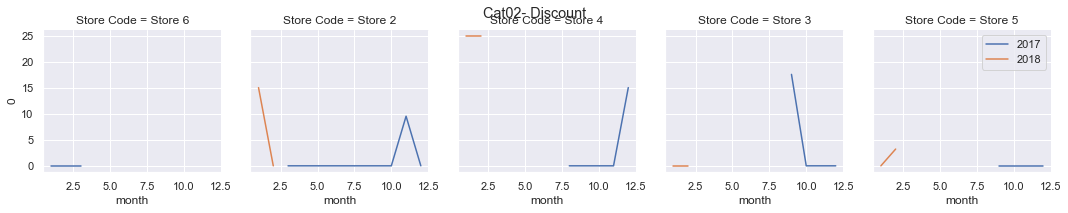

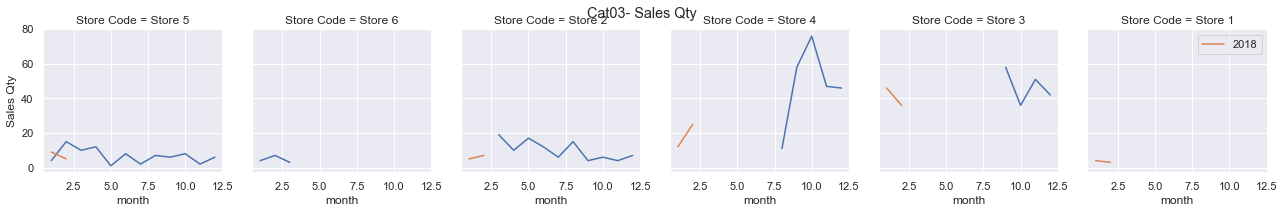

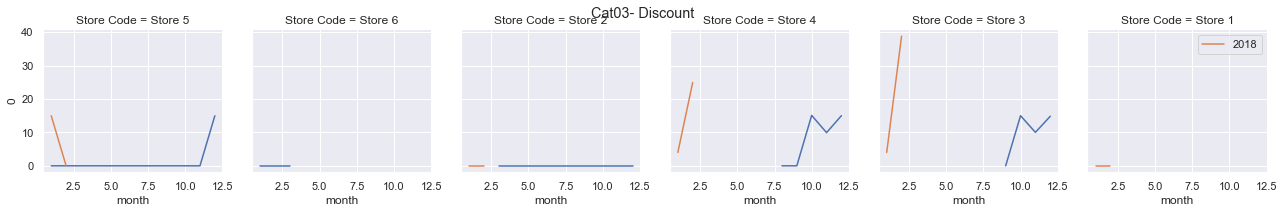

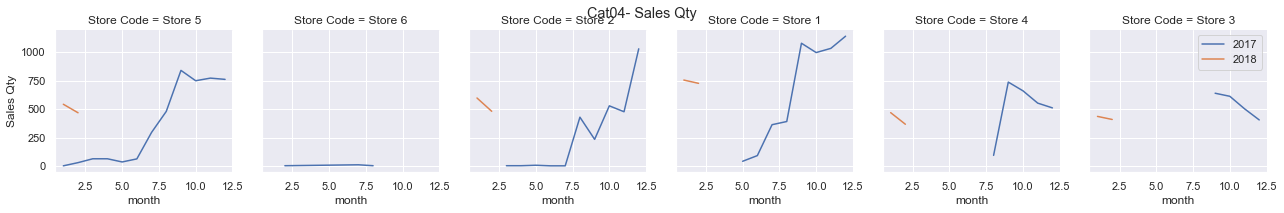

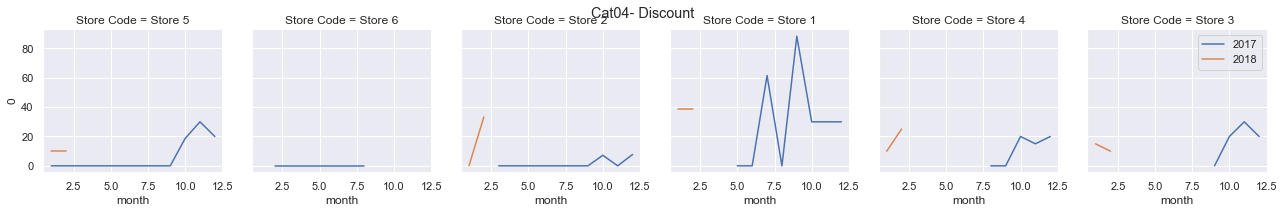

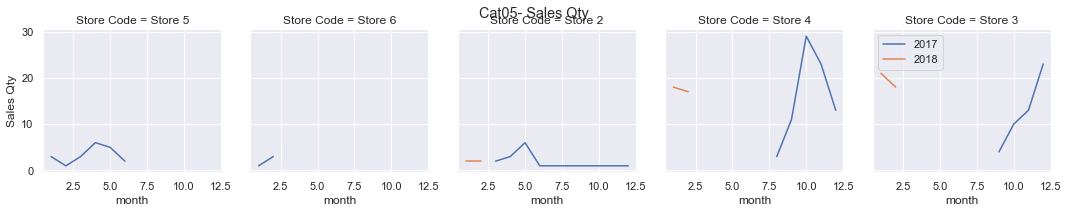

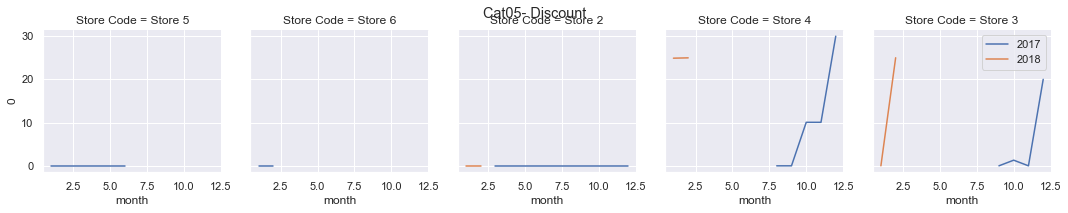

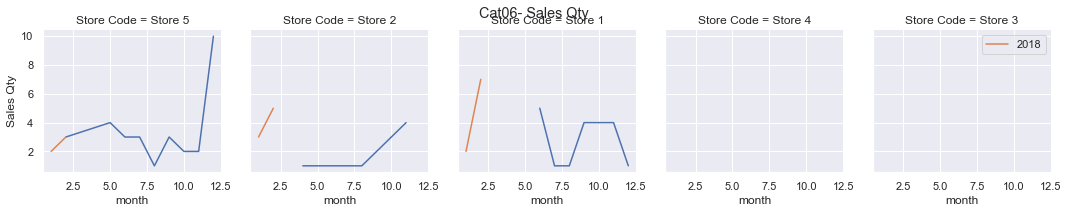

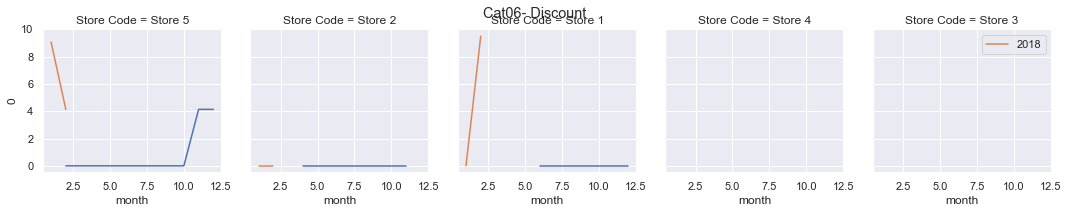

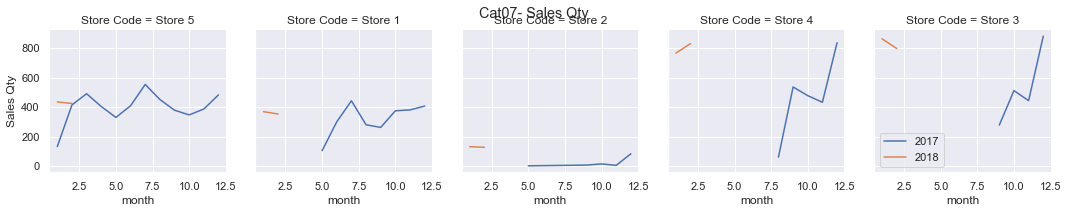

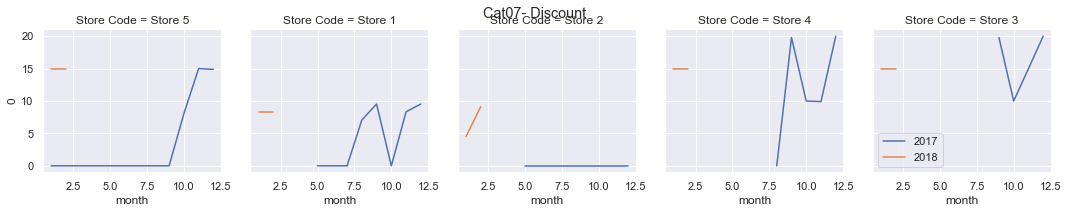

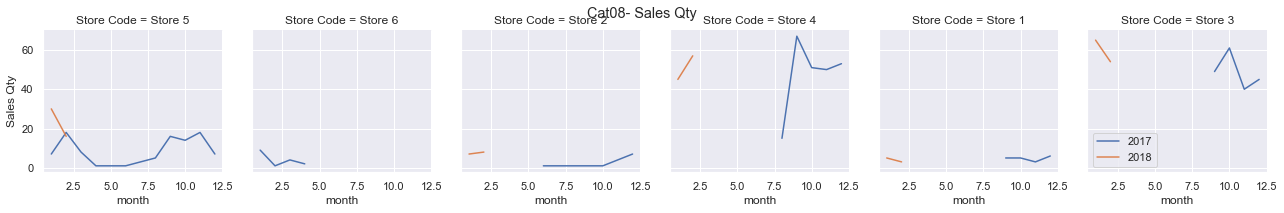

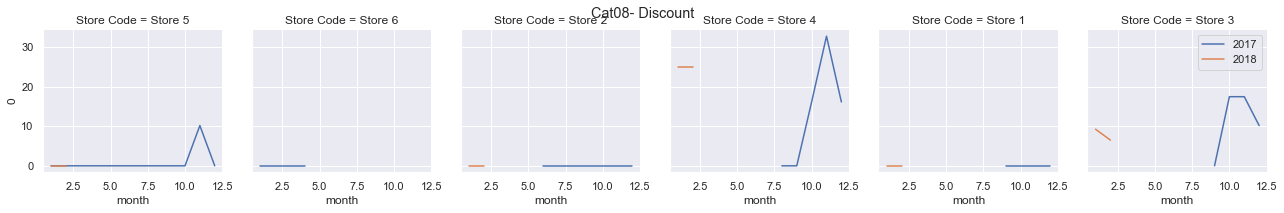

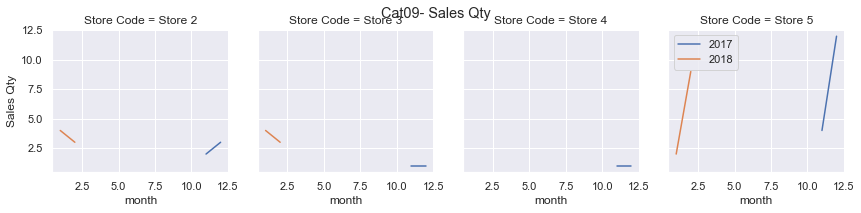

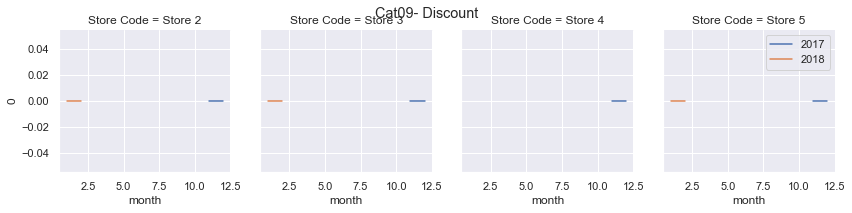

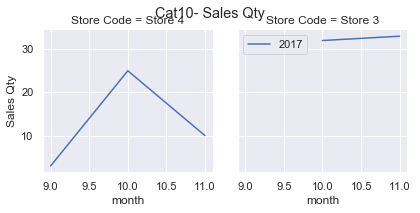

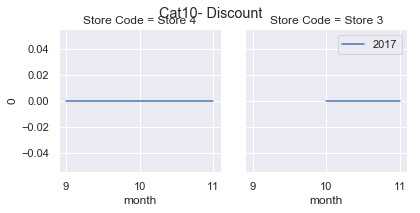

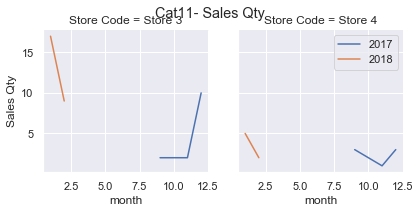

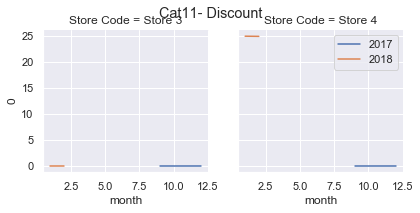

In [133]:
grouped = master_df.groupby(["Category"])

for category in categories:
    temp = grouped.get_group(category)
    frame = temp.groupby(["year", "month", "Store Code"])["Sales Qty"].sum().reset_index()

    if frame.shape[0] > 0:
        g = sns.FacetGrid(frame, col="Store Code", hue="year", margin_titles=True)
        g.map(plt.plot, "month", "Sales Qty")
        g.fig.suptitle(category + "- Sales Qty")
        
    plt.legend()
        
    frame = temp.groupby(["year", "month", "Store Code"]).apply(get_discount).reset_index()
 
    if frame.shape[0] > 0:
        g = sns.FacetGrid(frame, col="Store Code", hue="year", margin_titles=True)
        g.map(plt.plot, "month", 0)
        g.fig.suptitle(category + "- Discount")
    plt.legend()


In [166]:
from statsmodels.tsa.arima_model import ARIMA

In [167]:
model = ARIMA(df["Sales Qty"], order=(5,1,0))

D:\Anaconda\envs\py36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda\envs\py36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [168]:
model_fit = model.fit()

In [169]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Sales Qty   No. Observations:                 2366
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 238.522
Method:                       css-mle   S.D. of innovations              0.219
Date:                Sat, 22 Jun 2019   AIC                           -463.043
Time:                        17:53:14   BIC                           -422.660
Sample:                             1   HQIC                          -448.341
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -4.31e-09      0.002  -2.25e-06      1.000      -0.004       0.004
ar.L1.D.Sales Qty    -0.4606      0.020    -22.539      0.000      -0.501      -0.421
ar.L2.D.Sales Qty    -0.3351      0.022    -15.107      0.000      -0.379      -0.292
ar.L3.D.Sales Qty    -0.2530      0.023    -11.179      0.000      -0.297      -0.209
ar.L4.D.Sales Qty    -0.1895      0.022     -8.550      0.000      -0.233      -0.146
ar.L5.D.Sales Qty    -0.1077      0.020     -5.273      0.000      -0.148      -0.068
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7694           -1.2216j            1.4437           -0.1605
AR.2            0.7694           +1.2216j            1.4437            0.1605
AR.3           -1.6987           -0.0000j            1.6987           -0.5000
AR.4           -0.8004           -1.4081j            1.6197           -0.3323
AR.5           -0.8004           +1.4081j            1.6197            0.3323
-----------------------------------------------------------------------------
"""

In [170]:
residuals = pd.DataFrame(model_fit.resid)

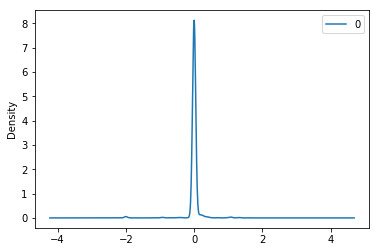

In [171]:
residuals.plot(kind="kde")

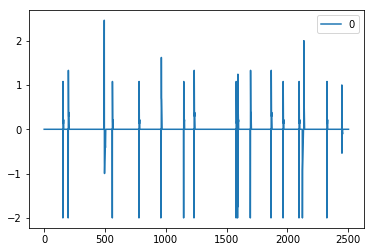

In [172]:
residuals.plot()

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
ss = StandardScaler()

In [23]:
ss.fit_transform(np.array(df["Sales Qty"]).reshape(len(df),1))

D:\Anaconda\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[0.09918482],
       [0.09918482],
       [0.09918482],
       ...,
       [0.09918482],
       [0.09918482],
       [0.09918482]])

D:\Anaconda\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda\envs\py36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by 

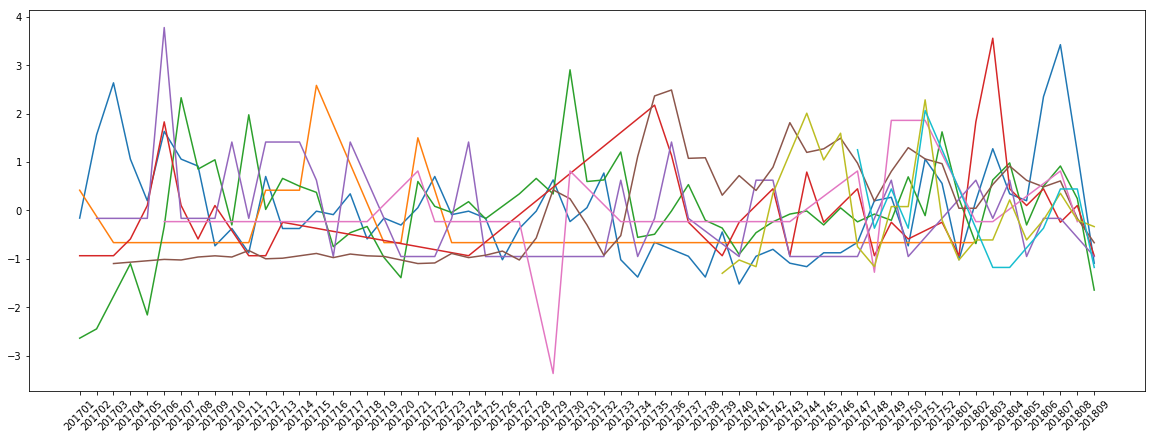

In [24]:
df = features_dfs[4]
grouped_df = df.groupby(["year_week","Category"])["Sales Qty"].sum().reset_index()

plt.figure(figsize=(20,7))

for cat in grouped_df["Category"].unique():
    df = grouped_df[grouped_df["Category"] == cat]
    
    plt.plot(df["year_week"], ss.fit_transform(np.array(df["Sales Qty"]).reshape(len(df),1)))

    
_ = plt.xticks(rotation=45)


In [124]:
# grouped_df[grouped_df["Category"] == cat].rolling(3).mean()

def get_rolling_stats(df, n=12):
    df["rolling_mean"] = df.rolling(n, min_periods=4)["Sales Qty"].mean()
    df["rolling_dev"] = df.rolling(n, min_periods=4)["Sales Qty"].std()
    df["rolling_z"] = df.apply(lambda x: (x["Sales Qty"] - x["rolling_mean"])/x["rolling_dev"], axis=1)
    return df
    


D:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

D:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

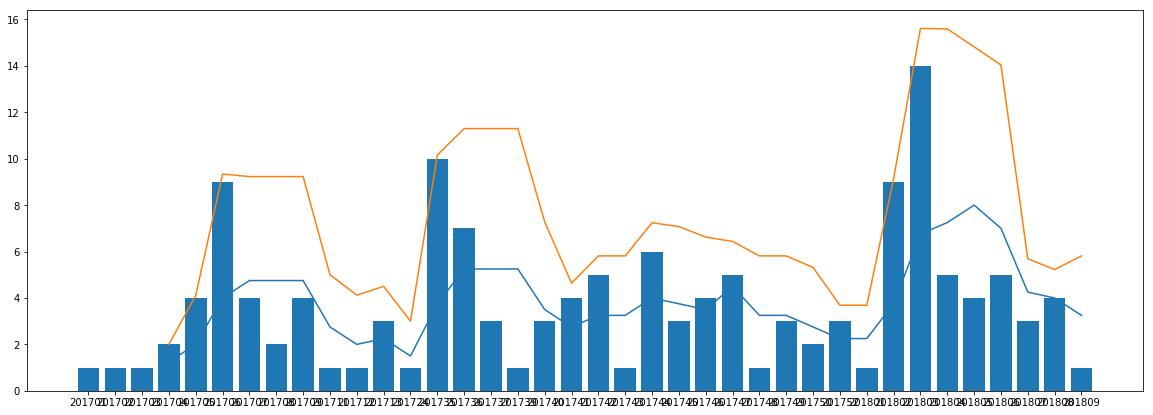

In [139]:
df = get_rolling_stats(grouped_df[grouped_df["Category"] == "Cat08"], n=4)
plt.figure(figsize=(20,7))
plt.bar(df["year_week"], df["Sales Qty"])
plt.plot(df["year_week"], df["rolling_mean"])
plt.plot(df["year_week"], df["rolling_mean"]+ 1.5*df["rolling_dev"])

,year_week,Category,Sales Qty,rolling_mean,rolling_dev,rolling_z
0,201701,Cat01,31,NaN,NaN,NaN
4,201702,Cat01,55,NaN,NaN,NaN
8,201703,Cat01,70,NaN,NaN,NaN
14,201704,Cat01,48,51.000000,16.186414,-0.185341
17,201705,Cat01,36,48.000000,15.540270,-0.772187
22,201706,Cat01,56,49.333333,14.278188,0.466913
28,201707,Cat01,48,49.142857,13.043882,-0.087616
33,201708,Cat01,46,48.750000,12.127301,-0.226761
39,201709,Cat01,23,47.750000,13.987239,-1.769470
45,201710,Cat01,28,44.375000,15.193396,-1.077771


In [120]:
df.plot("year_week", "rolling_z")

KeyError: 'rolling_z'

In [121]:
df[df["rolling_z"] > 1.5]

KeyError: 'rolling_z'

In [122]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

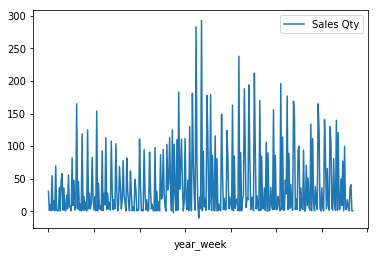

In [123]:
grouped_df.plot("year_week", "Sales Qty")

In [117]:
plt.figure(figsize=(20,7))
plt.bar(df["year_week"], df["rolling_z"])
_ = plt.xticks(rotation=45)

KeyError: 'rolling_z'

<Figure size 1440x504 with 0 Axes>

In [507]:
### Return Data Analysis
def return_data_analysis(df):
    df =  df[df["Sale/Return"]=="Return"]
    df.groupby("Category")["Sales Qty"].sum()
    df["Amount"] = df["Sales Price"] * df["Sales Qty"]
    

In [125]:
df.groupby(["Category","Brand Code", "SKU Code"])["Sales Qty"].apply(sum)

Category  Brand Code  SKU Code
Cat01     BRAND001    SKU0011      7
                      SKU0027      6
                      SKU0032      1
                      SKU0043      1
                      SKU0081      1
                      SKU0101      9
                      SKU0158      3
                      SKU0168      1
                      SKU0234      3
                      SKU0239      1
                      SKU0257      8
                      SKU0331      1
                      SKU0384      5
                      SKU0421      6
                      SKU0438      2
                      SKU0449      2
                      SKU0514      5
                      SKU0538      4
                      SKU0676      3
                      SKU0677      2
                      SKU0679      1
                      SKU0703      7
                      SKU1114      3
                      SKU2964      1
                      SKU3918      2
                      SKU3962      3
       

In [148]:
df["week"] = pd.to_datetime(df["Sale Date"]).dt.week 
df["Amount"] = df["Sales Price"] * df["Sales Qty"]

KeyError: 'week'

<BarContainer object of 61 artists>

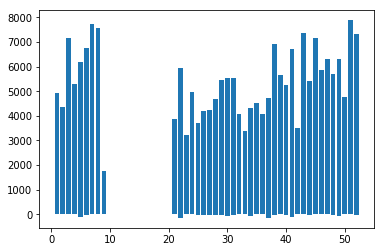

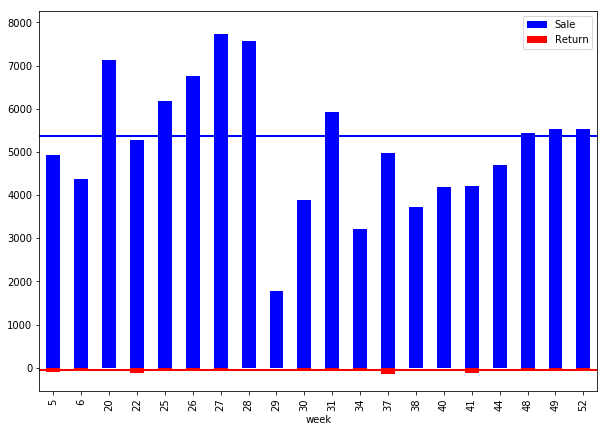

In [163]:
margin_bottom

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [180]:
df.plot.bar?